In [1]:
from collections import Counter
import itertools
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from unseal.hooks import Hook, HookedModel
from unseal.hooks.common_hooks import save_output

from circuits_util import get_o_weight, get_qkv_weights
from datasets import get_dataset
from model import GrokkingTransformer
from utils import load_model

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

if device == 'cpu':
    logging.warning('No GPU found! Using CPU')

In [44]:
model_name = 'Single Layer ReLU'
ckpt, ckpt_dir = load_model(model_name)

# model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
model = GrokkingTransformer.load_from_checkpoint(os.path.join(ckpt_dir, "epoch=600-step=6009.ckpt")).to(device)
model.eval()

key_layer = model.transformer[0].linear_net[0].weight
value_layer = model.transformer[0].linear_net[-1].weight

In [45]:
neurons = [204, 219, 222, 403]
values = {neuron: value_layer[:, neuron] for neuron in neurons}

In [46]:
# What's the distribution over key magnitudes for these three value vectors, over the whole dataset?
# Which inputs activate them the most?
dataset = torch.from_numpy(get_dataset(descr='minus', num_elements=97, data_dir='./data').data).to(device)

In [47]:
hooked_model = HookedModel(model)
save_key_mag_hook = Hook("transformer->0->linear_net->2", save_output(), key="save_key_magnitude")
save_pre_key_hook = Hook("transformer->0->norm1", save_output(), key="save_pre_key")
save_embedded_hook = Hook("pos_encoding", save_output(), key="save_embedded")
save_attn_out_hook = Hook("transformer->0->self_attn", save_output(), key="save_attn_out")
hooked_model(dataset[:,:-1], hooks=[save_key_mag_hook, save_pre_key_hook, save_embedded_hook, save_attn_out_hook])
print('')

In [48]:
key_magnitude = hooked_model.save_ctx['save_key_magnitude']['output'][:,-1,neurons]
print(key_magnitude.shape)
num_non_zeros = [len(key_magnitude[key_magnitude[:,i] != 0, i]) for i in range(len(neurons))]
print(num_non_zeros)

torch.Size([9409, 4])
[4195, 5752, 4403, 4624]


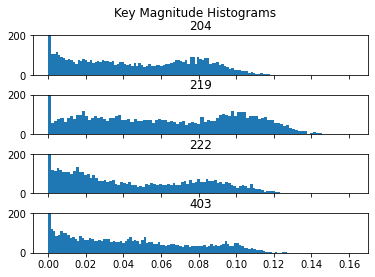

In [25]:
fig, axes = plt.subplots(len(neurons), 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})
for i in range(len(neurons)):
    axes[i].hist(key_magnitude[:,i].detach().numpy(), bins=100)
    axes[i].set_title(f"{neurons[i]}")
# plt.xlim(0.000, 0.041)
plt.ylim(0,200)
plt.suptitle(f"Key Magnitude Histograms")
plt.show()

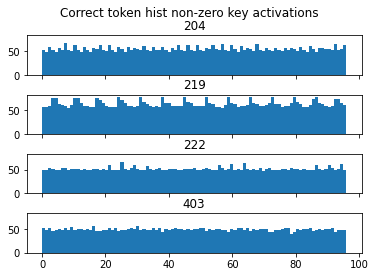

In [12]:
# get the data points to the largest 100 magnitudes


fig, axes = plt.subplots(len(neurons), 1, sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})
for i, key in enumerate(neurons):
    axes[i].hist(dataset[key_magnitude[:,i] != 0][:,-1].cpu().numpy(), bins=97)
    axes[i].set_title(f"{key}")
plt.suptitle('Correct token hist non-zero key activations')
plt.show()

In [13]:
# value_logits = {key: model.output(values[key]) for key in values.keys()}
value_logits = {key: model.output(model.transformer[0].norm2.weight * values[key]) for key in values.keys()}
# subtract mean to center logits
value_logits = {key: value_logits[key] - torch.mean(value_logits[key]) for key in values.keys()}

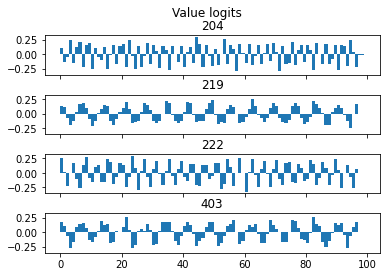

In [15]:
fig, ax = plt.subplots(len(neurons),1,sharex=True, sharey=True, gridspec_kw={'hspace': 0.5})
for i, key in enumerate(neurons):
    ax[i].bar(np.arange(len(value_logits[key])), value_logits[key].detach().cpu().numpy(), width=1, align='edge')
    ax[i].set_title(f"{key}")
plt.suptitle('Value logits')
plt.savefig(os.path.join(model_name, 'value_logits.png'))
plt.show()

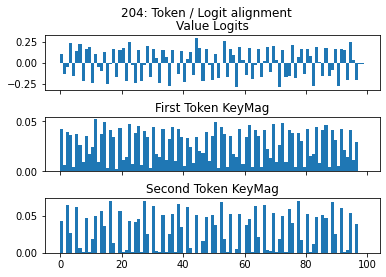

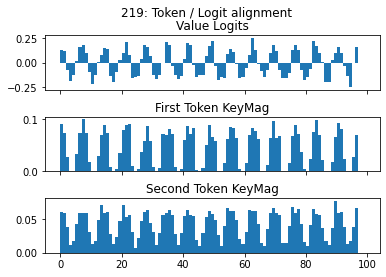

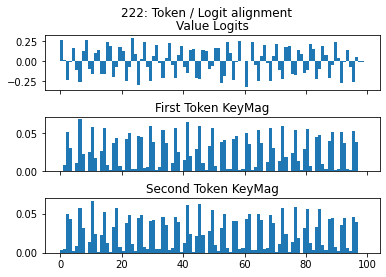

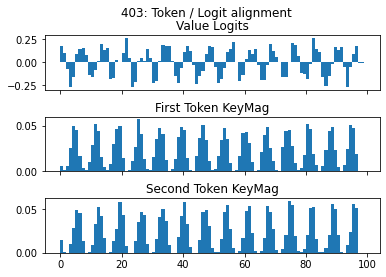

In [16]:
for j, neuron in enumerate(neurons):
    fig, ax = plt.subplots(3,1,sharex=True, gridspec_kw={'hspace': 0.5})
    ax[0].bar(np.arange(len(value_logits[neuron])), value_logits[neuron].detach().cpu().numpy(), width=1, align='edge')
    ax[0].set_title(f"Value Logits")
    ax[1].set_title(f"First Token KeyMag")
    keymag1 = []
    for i in range(97):
        keymag1.append(key_magnitude[(dataset[:,0]==i).cpu(), j].mean().detach().numpy())
    ax[1].bar(np.arange(len(keymag1)), keymag1, width=1, align='edge')

    ax[2].set_title(f"Second Token KeyMag")
    keymag2 = []
    for i in range(97):
        keymag2.append(key_magnitude[(dataset[:,2]==i).cpu(), j].mean().detach().numpy())
    ax[2].bar(np.arange(len(keymag2)), keymag2, width=1, align='edge')


    plt.suptitle(f'{neuron}: Token / Logit alignment')
    plt.savefig(f'{model_name}/logit_keymag_align_{neuron}.png')
    
    plt.show()

Text(0.5, 1.0, 'Value Logits')

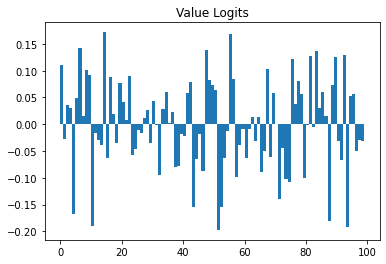

In [45]:
# compute logit effect of all four relevant neurons
plt.bar(np.arange(len(value_logits[204])), np.mean(np.array([value_logits[neuron].detach().cpu().numpy() for neuron in [204,219,222,403]]), axis=0), width=1, align='edge')
plt.title(f"Value Logits")

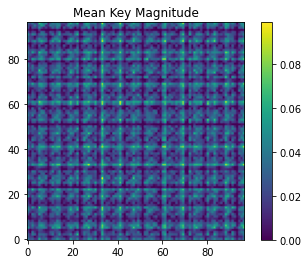

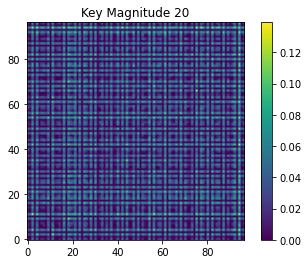

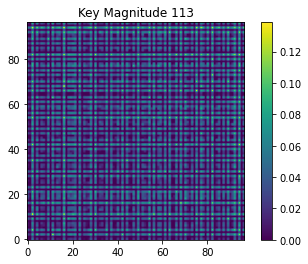

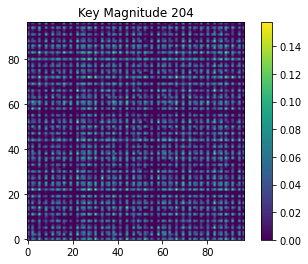

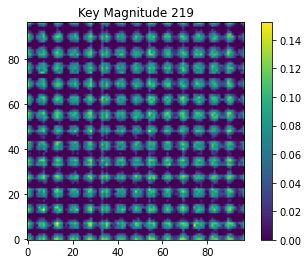

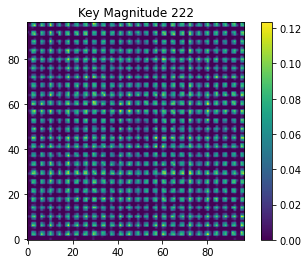

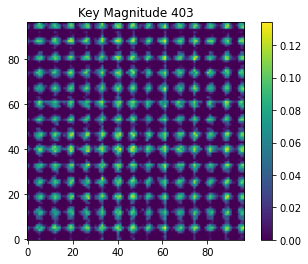

In [63]:

plt.figure()
plt.imshow(np.mean(key_magnitude[:,[neurons.index(neuron) for neuron in [204, 219, 222, 403]]].reshape(97,97,-1).detach().cpu().numpy(), axis=-1), origin='lower', cmap='viridis')
plt.colorbar()
plt.title(f'Mean Key Magnitude')
plt.show()

for i, neuron in enumerate(neurons):
    plt.figure()
    plt.imshow(key_magnitude[:,i].reshape(97,97).detach().cpu().numpy(), origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title(f'Key Magnitude {neuron}')
    plt.savefig(f'{model_name}/key_magnitude_{neuron}.png')
    plt.show()




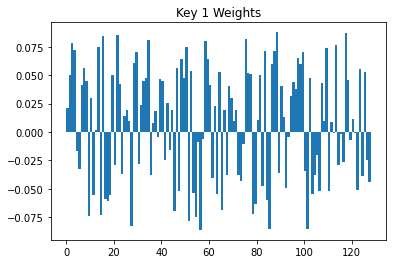

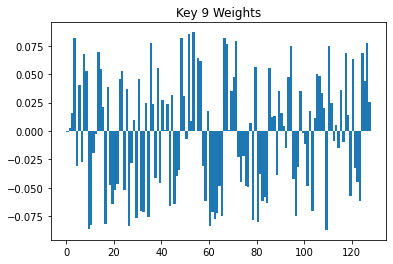

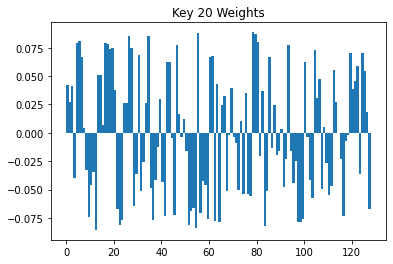

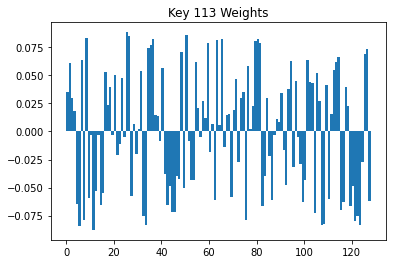

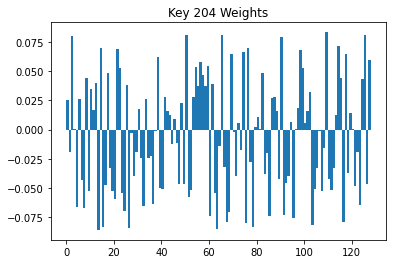

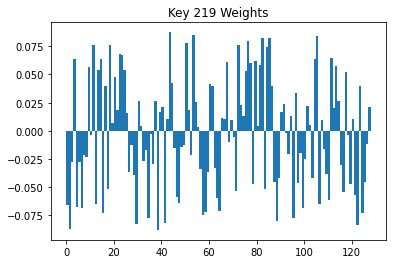

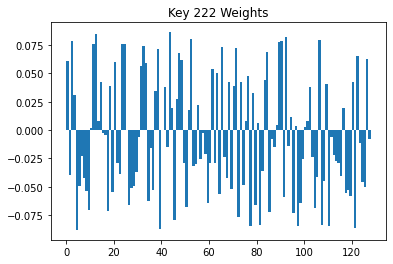

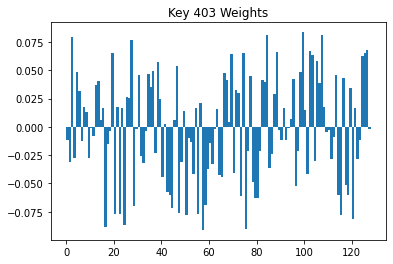

In [14]:
for i, neuron in enumerate(neurons):
    plt.figure()
    plt.bar(np.arange(128), key_layer[neuron,:].detach().cpu().numpy(), width=1, align='edge')
    plt.title(f'Key {neuron} Weights')
    plt.show()

tensor([ 0, 97,  0, 98,  0], device='cuda:0')
tensor([ 5, 97, 11, 98, 91], device='cuda:0')
(2, 128)


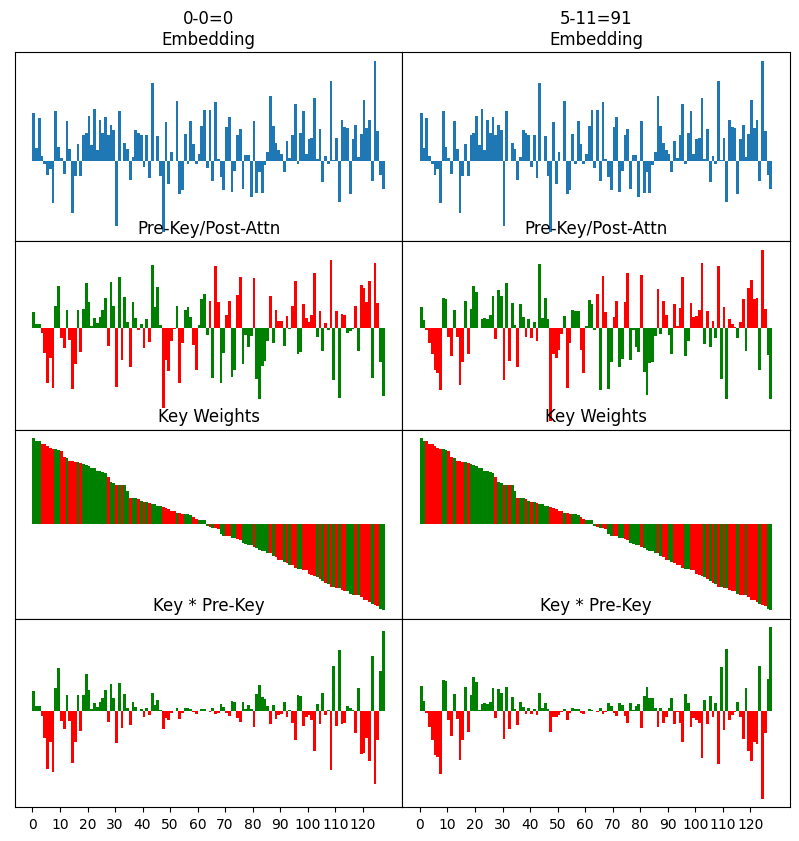

In [15]:
pre_key = hooked_model.save_ctx['save_pre_key']['output'][:,-1].detach().cpu().numpy()

idx1 = 0
idx2 = 5*98 + 6
print(dataset[idx1])
print(dataset[idx2])


embedded = hooked_model.save_ctx['save_embedded']['output'][[idx1,idx2],-1].numpy()
pre_key = hooked_model.save_ctx['save_pre_key']['output'][[idx1,idx2],-1].numpy()
key_matrix = key_layer[219,:].detach().cpu().numpy()
key_pre_key_sign_agreement = np.sign(key_matrix[None] * pre_key)
print(key_pre_key_sign_agreement.shape)
pre_sum = key_matrix[None] * pre_key
colors = np.array([list(map(lambda x: 'green' if x == 1 else 'red', key_pre_key_sign_agreement[i])) for i in range(2)])
sort_idcs = key_matrix.argsort()[::-1]
fig, ax = plt.subplots(4, 2,sharex=True, gridspec_kw={'hspace': 0., 'wspace': 0.}, figsize=(10,10), dpi=100)
for i in range(4):
    for j in range(2):
        if i > 0:
            ax[i,j].bar(np.arange(128), [embedded, pre_key, [key_matrix,key_matrix], pre_sum][i][j][sort_idcs], color=colors[j][sort_idcs], width=1, align='edge')
            ax[i,j].set_title(['Pre-Key/Post-Attn', 'Key Weights', 'Key * Pre-Key'][i-1])
        else:
            ax[i,j].bar(np.arange(128), [embedded, pre_key, [key_matrix,key_matrix], pre_sum][i][j][sort_idcs], width=1, align='edge')
            ax[i,j].set_title(['0-0=0\nEmbedding', '5-11=91\nEmbedding'][j])
        # remove ticks
        if j == 1:
            ax[i,j].sharey(ax[i,0])
        
        if i < 3:
            ax[i,j].set_xticks([])
        
        else:
            ax[i,j].set_xticks(np.arange(0,128,10))
        ax[i,j].set_yticks([])
plt.show()

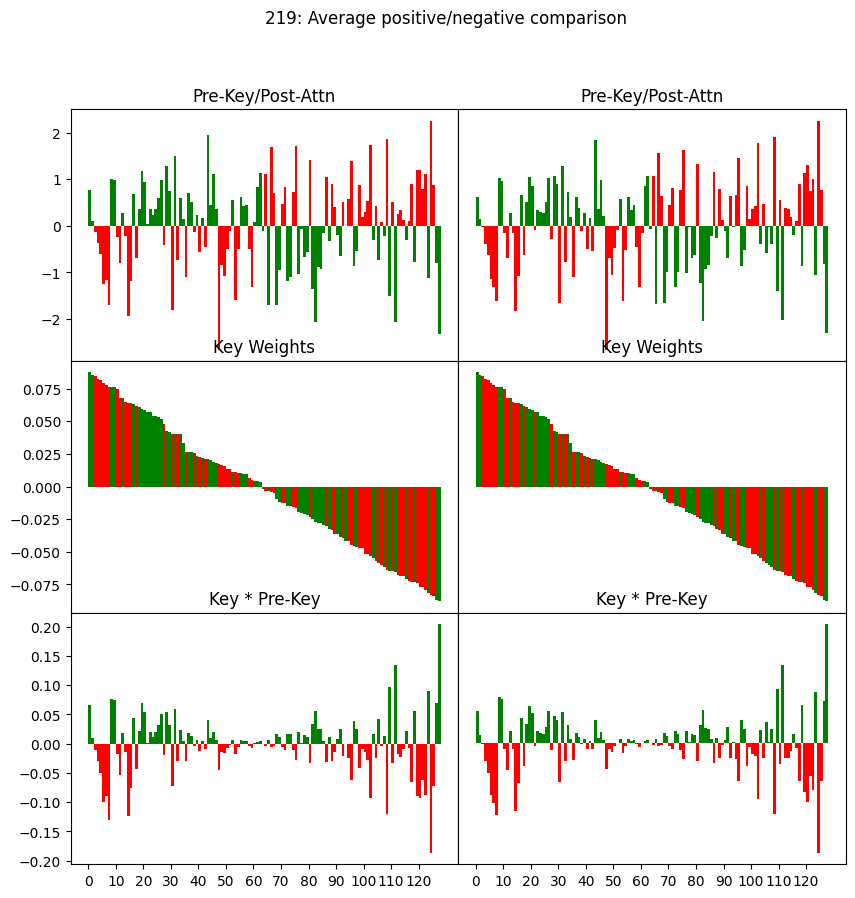

In [16]:
# average of the last row over positive examples
pre_key = hooked_model.save_ctx['save_pre_key']['output'][:,-1].detach().cpu().numpy()

pos_idcs = [(m*7+n*7*97) % 9409 for m, n in itertools.product(range(13), repeat=2)]
neg_idcs = [(5+5*97+m*7+n*7*97) % 9409 for m, n in itertools.product(range(13), repeat=2)]

pos_pre_key = hooked_model.save_ctx['save_pre_key']['output'][pos_idcs,-1].numpy().mean(axis=0)
neg_pre_key = hooked_model.save_ctx['save_pre_key']['output'][neg_idcs,-1].numpy().mean(axis=0)
key_matrix = key_layer[219,:].detach().cpu().numpy()
pos_key_pre_key_sign_agreement = np.sign(key_matrix * pos_pre_key)
neg_key_pre_key_sign_agreement = np.sign(key_matrix * neg_pre_key)
pos_pre_sum = key_matrix * pos_pre_key
neg_pre_sum = key_matrix * neg_pre_key
colors = [np.array(list(map(lambda x: 'green' if x == 1 else 'red', pos_key_pre_key_sign_agreement))), np.array(list(map(lambda x: 'green' if x == 1 else 'red', neg_key_pre_key_sign_agreement)))]
sort_idcs = key_matrix.argsort()[::-1]
fig, ax = plt.subplots(3, 2,sharex=True, gridspec_kw={'hspace': 0., 'wspace': 0.}, figsize=(10,10), dpi=100)
for i in range(3):
    for j in range(2):
        ax[i,j].bar(np.arange(128), [[pos_pre_key, neg_pre_key], [key_matrix, key_matrix], [pos_pre_sum, neg_pre_sum]][i][j][sort_idcs], color=colors[j][sort_idcs], width=1, align='edge')
        ax[i,j].set_title(['Pre-Key/Post-Attn', 'Key Weights', 'Key * Pre-Key'][i])
    
    # remove ticks
    if i < 2:
        ax[i,j].set_xticks([])
        
    else:
        ax[i,j].set_xticks(np.arange(0,128,10))
    ax[i,j].set_yticks([])
plt.suptitle('219: Average positive/negative comparison')
plt.show()

In [17]:
largest_dims = sort_idcs[:10]
smallest_dims = sort_idcs[-10:]
print(largest_dims)
print(smallest_dims)

pos_dims = [largest_dims[0]] + [largest_dims[2]]
neg_dims = [sort_idcs[3]] + [sort_idcs[-4]]
print(pos_dims)
print(neg_dims)

[ 43  53 105  82  85  76  50  72  11  18]
[ 15  57  95  34  88  41  29 122   1  38]
[43, 105]
[82, 29]


In [18]:
o = get_o_weight(model.transformer[0].self_attn)
q, k, v = get_qkv_weights(model.transformer[0].self_attn)
ov = torch.einsum('bij,bik->bjk', o, v).detach().cpu().numpy()
print(f"{ov.shape = }")

ov.shape = (4, 128, 128)


In [19]:
largest_ov = ov[:,largest_dims]
smallest_ov = ov[:,smallest_dims]
pos_ov = ov[:,pos_dims]
neg_ov = ov[:,neg_dims]

# shape = (batch_size, num_heads, seq_len)
attn = hooked_model.save_ctx['save_attn_out']['output'][1][:,:,-1] # attn that equal sign pays to other tokens

# shape = (batch_size, seq_len, embedding_dim)
pre_attn = hooked_model.save_ctx['save_embedded']['output']

# shape = (batch_size, num_heads, seq_len, embedding_dim)
attn_weighted = pre_attn[:,None] * attn[...,None]  

# mean value that is written to dimensions 65 and 13 by each head, unweighted by attention, so maybe I should weight this with attention!!
# shape = [batch, heads, seq_len, pos_dims]
print('pos')
print(np.einsum('aij,bakj->baki', pos_ov, attn_weighted[pos_idcs].detach().numpy()).sum(axis=2).mean(axis=0))

print('\nneg')
print(np.einsum('aij,bakj->baki', neg_ov, attn_weighted[neg_idcs].detach().numpy()).sum(axis=2).mean(axis=0))

pos
[[-0.4135115  -0.47903055]
 [ 0.5266841  -0.17619447]
 [ 0.23797484 -0.06183047]
 [-0.01952773 -0.23491472]]

neg
[[-0.8532518  -0.2680715 ]
 [ 0.01317579 -0.07324719]
 [ 0.44513038 -0.07744351]
 [ 0.42010596  0.32060564]]


In [20]:
print(largest_ov[0].shape)
print(hooked_model.save_ctx['save_embedded']['output'][idx1,0].shape)
for i in range(4):
    print(f'{i}')
    print(largest_ov[i] @ hooked_model.save_ctx['save_embedded']['output'][idx2,0].numpy() - largest_ov[i] @ hooked_model.save_ctx['save_embedded']['output'][idx1,0].numpy())
    print(smallest_ov[i] @ hooked_model.save_ctx['save_embedded']['output'][idx2,0].numpy() - smallest_ov[i] @ hooked_model.save_ctx['save_embedded']['output'][idx1,0].numpy())

(10, 128)
torch.Size([128])
0
[-0.15024295 -0.9365162  -0.33681616  0.04346555  0.13721435 -0.38518777
 -0.67146456 -0.79806113  0.610474    0.3332156 ]
[ 0.5919671  -0.2682655   0.3456513   0.043199    0.29853255 -0.40296328
  0.01057132 -0.24030888 -0.27443573  0.3855151 ]
1
[ 0.2210767  -0.08110169  0.6901916   0.33692032  0.940602   -0.34667695
  0.1688411   0.5879696   0.11119413 -0.9668957 ]
[ 0.9474162  -0.26883557 -0.06464623 -0.9088656   0.14207861 -0.60007054
  1.2076411  -0.6975945  -0.280061    0.63574976]
2
[ 0.18432021 -0.13209967  0.13490862 -0.20404023  0.3850239   0.27608043
 -0.34940577 -0.35092223 -0.4419626   0.70769095]
[-0.4361649   0.29355913 -0.41971195  0.23294008 -0.09401426 -0.17487207
  0.45148695 -0.4308957  -0.23047508  0.5744851 ]
3
[-0.3844793  -1.3412044   0.9571212  -0.48041004 -0.07476814 -0.47382957
  1.559684   -0.05668609 -0.9120362   0.34238923]
[-0.53971237  0.69732     0.32398456 -0.7905091  -0.33855587  0.53473926
 -0.7750194  -0.34786212  0.42